In [28]:
# Cargar paquetes
import numpy as np      
import pandas as pd     
import matplotlib.pyplot as plt 

# Modulos para redes neuronales
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras import regularizers
from keras.constraints import max_norm

# Tratamiento de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
# Lectura de datos
df = pd.read_csv("datos.csv", sep=";")
cols = df.columns

# Identificamos valores perdidos: No hay valores perdidos en ninguna de las variables.
# df.isna().sum()

# Separar las variables predictoras de la etiqueta
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

y = pd.Categorical(y).codes
print(y)

# Le damos valor a random_statte para obtener una salida reproducible  
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    shuffle=True, random_state=123,
                                                    stratify=y)

# Proporcion de las clases en los diferentes conjuntos
# Las clases están bantante balanceadas, todas representan alrededor de un 22% de la muestra en los diferentes conjuntos.
print("Proporción para y", np.unique(y, return_counts=True)[1]/y.shape[0])
print("Proporción para y_train", np.unique(y_train, return_counts=True)[1]/y_train.shape[0])
print("Proporción para y_test", np.unique(y_test, return_counts=True)[1]/y_test.shape[0])



[3 1 1 ... 3 1 1]
Proporción para y [0.24233403 0.23563561 0.25826139 0.26376898]
Proporción para y_train [0.24227763 0.23557871 0.25828061 0.26386304]
Proporción para y_test [0.24255952 0.2358631  0.25818452 0.26339286]


In [34]:
# Nombres de variables numericas --> normalizacion
num_var = X.select_dtypes(include=['number']).columns.values
num_var

# Nombres de variables categoricas --> codificacion one-hot
cat_var = X.select_dtypes(include=['object']).columns.values
cat_var

transformer = make_column_transformer(
    (StandardScaler(), num_var),
    (OneHotEncoder(), cat_var),
    verbose_feature_names_out=False)
# Si no ponemos verbose_feature_names_out=False incorpora standardscaler/onehotencoder
# delante del nombre de cada variable

# Ajustamos utilizando informacion del conjunto de entrenamiento
transformer.fit(x_train)

# Entrenamiento. Pasamos de 9 a 20 variables
x_train = transformer.transform(x_train)
x_train = pd.DataFrame(x_train)

# Test
x_test = transformer.transform(x_test)
x_test = pd.DataFrame(x_test)

x_train.columns
x_train.head(5)

x_test.columns
x_test.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.298059,-1.543337,1.276941,-0.745013,0.103021,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.695473,-0.998319,-0.774213,-0.745013,0.760546,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.460286,0.152273,-0.774213,0.606219,0.103021,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.648605,-0.695532,-0.188169,-0.745013,0.103021,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.234147,2.392899,-0.481191,1.957450,-0.554503,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
y_test = keras.utils.to_categorical(y_test, num_classes=4)
y_train = keras.utils.to_categorical(y_train, num_classes=4)

In [50]:
modelo = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(32, activation="relu"),
        Dense(32, activation="relu"),
        Dense(4, activation='softmax')])

# Veamos los detalles del modelo
modelo.summary()

# Planificacion con decrecimiento exponencial de la tasa de aprendizaje 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.1, # tasa de aprendizaje inicial
    decay_steps=500,  
    decay_rate=0.96)

#  Compilacion
modelo.compile(loss = 'categorical_crossentropy', 
               optimizer='adam',
               metrics = ['accuracy'])

# Early stoping
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                           patience = 5,
                                           restore_best_weights=True)

# Entrenamiento del modelo
history = modelo.fit(x_train, y_train, epochs=1000, batch_size=64, validation_split=0.2, callbacks=[early_stop])


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,860 (7.27 KB)

 Trainable params: 1,860 (7.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4232 - loss: 1.2907 - val_accuracy: 0.4847 - val_loss: 1.1891
Epoch 2/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4718 - loss: 1.1831 - val_accuracy: 0.4902 - val_loss: 1.1343
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5060 - loss: 1.1165 - val_accuracy: 0.5153 - val_loss: 1.1059
Epoch 4/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5127 - loss: 1.0887 - val_accuracy: 0.5228 - val_loss: 1.0898
Epoch 5/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5177 - loss: 1.0765 - val_accuracy: 0.5274 - val_loss: 1.0831
Epoch 6/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5222 - loss: 1.0665 - val_accuracy: 0.5293 - val_loss: 1.0804
Epoch 7/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5398 - loss: 1.0469 - val_accuracy: 0.5330 - val_loss: 1.0768
Epoch 8/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5538 - loss: 1.0285 - val_accuracy: 0.

In [48]:
modelo.save('GavaldaNataliainicial.keras')

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4942 - loss: 1.1130
Precisión en test: 0.5119
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
    accuracy      loss  val_accuracy  val_loss
0   0.437544  1.257062      0.484651  1.189126
1   0.486392  1.156502      0.490233  1.134341
2   0.505466  1.110187      0.515349  1.105916
3   0.518260  1.084043      0.522791  1.089842
4   0.527099  1.070837      0.527442  1.083148
5   0.532449  1.060838      0.529302  1.080375
6   0.540591  1.053790      0.533023  1.076760
7   0.539195  1.049309      0.538605  1.073937
8   0.541056  1.044155      0.541395  1.074983
9   0.542684  1.040532      0.533023  1.077057
10  0.548732  1.036548      0.536744  1.071452
11  0.548965  1.032269      0.542326  1.071540
12  0.551058  1.031025      0.546046  1.070242
13  0.551058  1.027719      0.533953  1.068978
14  0.553617  1.026888      0.537674  1.068112
15  0.560130  1.022332      0.533953  1.068478
16  0.558269  1.019702      0.541395  1.06

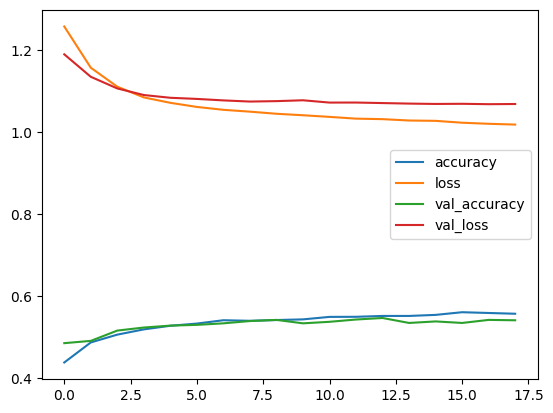

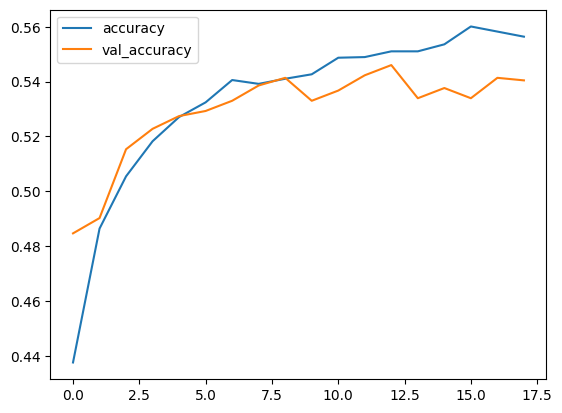

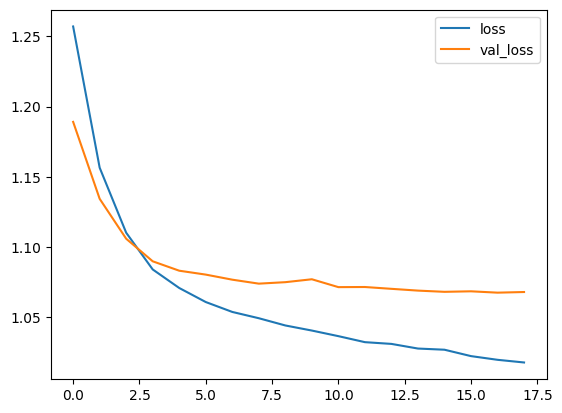

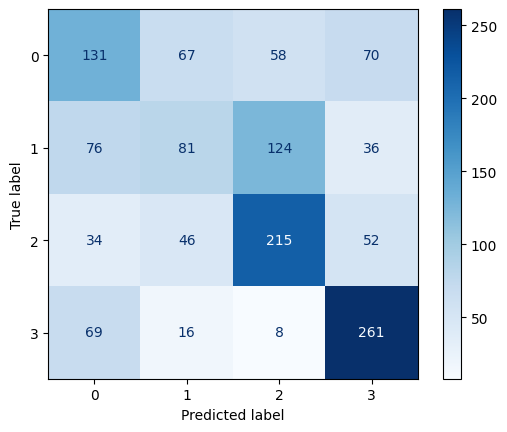

In [51]:
# Evaluación del modelo
loss, accuracy = modelo.evaluate(x_test, y_test)
print(f"Precisión en test: {accuracy:.4f}")

# Visualizmos el resultado
print(history.history.keys())
history = pd.DataFrame(history.history)
print(history)
history.plot()

# Representamos por separado la evolucion de la funcion de perdida y el accuracy
dfAccuracy = history.loc[:,["accuracy","val_accuracy"]]
dfAccuracy.plot()

dfLoss = history.loc[:,["loss","val_loss"]]
dfLoss.plot()

# Lo hacemos para todo el conjunto de test
predicciones = modelo.predict(x_test)

# Obtenemos la categoria donde se produce el maximo de la probabilidad de clasificacion
predic_test = np.argmax(predicciones, axis=1)
originales_test = np.argmax(y_test, axis=1) 

# Matriz de contingencia o matriz de confusion
conf_matrix = confusion_matrix(originales_test, predic_test)
    
# Print de la matriz de confusion
class_names = ['0','1','2','3']
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = class_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')

def accuracy_by_classs(conf_matrix):
    """
    Calcula el accuracy por clase a partir de una matriz de confusión.
    """
    class_acc = {}
    
    for i in range(len(conf_matrix)):  # Para cada clase
        TP = conf_matrix[i, i]  # Verdaderos positivos (diagonal)
        total_real = np.sum(conf_matrix[i, :])  # Total de ejemplos de esa clase (suma de la fila)
        
        accuracy = TP / total_real if total_real != 0 else 0  # Evitar división por 0
        class_acc[f"Clase {i}"] = accuracy
    
    return class_acc

# Accuracy por clase
accuracy_per_class = accuracy_by_classs(conf_matrix)

# Mostrar resultados
for clase, acc in accuracy_per_class.items():
    print(f"{clase}: {acc:.2%}")

# Conclusiones

Con el modelo simple ha tendido a sobreaprender. Lo he detectado porque el accuracy del cojunto de test vs el conjunto de train ha sido muy dispar. Además también se puede ver en la gráfica, donde la línea naranja se va separando más todavía de la línea azul. Si no hubiera sobreaprendizaje, ambas líneas tendrían que estar casi solapadas. Eso querría decir que no hay sobreaprendizaje y que el moddelo es capaz de generalizar bien.

Lo voy a abordar poniendo una tasa de aprendizaje al 0.1 y añadiendo early stopping.

Accuracy de mi primer modelo: 0.69

La matriz de confusión se muestra anteriormente y el accuracy por clase es el siguiente:
- Clase 0: 40.18%
- Clase 1: 25.55%
- Clase 2: 61.96%
- Clase 3: 73.73%

La que peor predice es la clase 0 y 1. Parece que el modelo puede estar confundiendo también las clases 1 y 2 debido a que se ven que muchos casos que realmente es un tipo de cliente 1 se ha etiquetado como 2 y viceversa. Eso también pasa con la clase 0 y la clase 3. 